In [1]:
import numpy as np
from sklearn import svm, metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score

In [14]:
train = np.loadtxt("handout/train_triplets.txt", dtype=str, delimiter=" ")

features_file_name = "features_vgg16.pkl"
with open(features_file_name, 'rb') as f:
    features_dct = pkl.load(f)

features_arr = np.array(list(features_dct.values()))

steps = [('scaling', StandardScaler()), ('reduce_dim', PCA(n_components=100))]
pipeline = Pipeline(steps)

pipeline.fit(features_arr)

reduced_features_arr = pipeline.transform(features_arr)

reduced_features_dct = {}
for i, key in enumerate(features_dct.keys()):
    reduced_features_dct[key] = reduced_features_arr[i]

with open("reduced_features_vgg16.pkl", "wb") as f:
    pkl.dump(reduced_features_dct, f)

In [15]:
full_rows = []
for row in train:
    full_rows.append(np.hstack([reduced_features_dct[n] for n in row]))
train_man = np.vstack(full_rows)

if len(train)%2 != 0:
    idx = int((len(train_man) + 1) / 2)
else:
    idx = int(len(train_man) / 2)

train_man_one = train_man[:idx]
train_man_two = train_man[idx:]

sep = int(train_man.shape[1]/3)
t = np.copy(train_man_two[:, sep:(2*sep)])
train_man_two[:, sep:(2*sep)] = train_man_two[:, (2*sep):]
train_man_two[:, (2*sep):] = t

y_labels_one = np.ones(len(train_man_one))
y_labels_two = np.zeros(len(train_man_two))
y_labels = np.hstack([y_labels_one, y_labels_two])
x_train = np.vstack([train_man_one, train_man_two])

X_train, X_test, y_train, y_test = train_test_split(x_train, y_labels, test_size=0.2, random_state=42)

In [16]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

/work/gallim/anaconda3/envs/ML-projects/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/work/gallim/anaconda3/envs/ML-projects/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


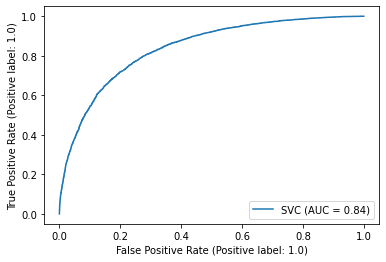

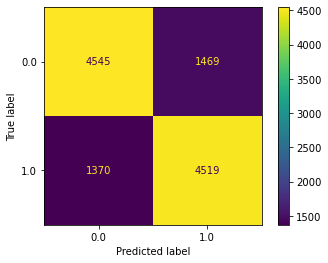

In [19]:
y_pred = clf.predict(X_test)
#y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
#print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")
plot_roc_curve(clf, X_test, y_test)
plot_confusion_matrix(clf, X_test, y_test);

In [20]:
(y_pred == y_test).sum() / len(y_test) 

0.7614887003276485

In [24]:
test = np.loadtxt("handout/test_triplets.txt", dtype=str, delimiter=" ")

full_rows = []
for row in test:
    full_rows.append(np.hstack([reduced_features_dct[n] for n in row]))
test_arr = np.vstack(full_rows)

In [25]:
predictions_int = clf.predict(test_arr)

In [26]:
predictions_int = predictions_int.astype(int)

In [27]:
np.savetxt("predictions/prediction_pipeline.txt", predictions_int, fmt="%i")